# 闪电级加速

[Make Your Pandas Code Lightning Fast \- YouTube](https://www.youtube.com/watch?v=SAFmrTnEHLg)


In [1]:
import matplotlib
print(matplotlib.__version__)

3.8.4


In [2]:
%load_ext memory_profiler

In [3]:
import pandas as pd, numpy as np

In [4]:
def get_data(size = 10_000):
    df = pd.DataFrame()
    size =10_000
    df['age'] = np.random.randint(0, 100, size)
    df['time_in_bed'] = np.random.randint(0,9,size)
    df['pct_sleeping']= np.random.rand(size)
    df['favorite_food'] = np.random.choice(['pizza','taco','ice-cream'], size)
    df['hate_food'] = np.random.choice(['broccoli','candy corn','eggs'], size)
    return df


In [5]:
df = get_data()
df.head()

,age,time_in_bed,pct_sleeping,favorite_food,hate_food
0,19,4,0.449805,pizza,candy corn
1,93,7,0.273745,pizza,candy corn
2,20,3,0.242331,ice-cream,broccoli
3,75,7,0.849347,ice-cream,candy corn
4,91,2,0.023806,taco,broccoli


## 任务

计算:

- 喜爱的食品: 在床 > 5 且 睡 > 50%
- 喜爱的食品: 如果 > 90岁
- 讨厌的食品: 其它情况



In [6]:
def reward_calc(row):
    if row['age'] >= 90:
        return row['favorite_food']
    if(row['time_in_bed']>5)&(row['pct_sleeping']> 0.5):
        return row['favorite_food']
    return row['hate_food']

### loop

In [7]:
%%timeit
df = get_data()
for index, row in df.iterrows():
    df.loc[index,'reward']= reward_calc(row)

756 ms ± 16.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### apply

In [8]:
%%timeit
df = get_data()
df['reward'] = df.apply(reward_calc,axis=1)

59.1 ms ± 1.45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### 矢量化 / vectorized

In [9]:
((df['pct_sleeping']>0.5)&(df['time_in_bed']>5))|(df['age']>90)

0       False
1        True
2       False
3        True
4        True
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Length: 10000, dtype: bool

In [10]:
%%timeit
df = get_data()
df['reward'] = df['hate_food']
df.loc[((df['pct_sleeping']>0.5)&
        (df['time_in_bed']>5))|
       (df['age']>90),
       'reward'] = df['favorite_food']

2.93 ms ± 72.5 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
df = get_data()

In [12]:
%%timeit
df['reward'] = df['hate_food']
df.loc[((df['pct_sleeping']>0.5)&
        (df['time_in_bed']>5))|
       (df['age']>90),
       'reward'] = df['favorite_food']

516 μs ± 13 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## 结论

In [13]:
results = pd.DataFrame(
    [
        ["loop",756, 16.1],
        ["apply",59.1,1.45],
        ["vectorized",2.93,0.0073],
    ],
    columns=["type","mean","std"]
)

In [14]:
results.set_index('type')['mean']

type
loop          756.00
apply          59.10
vectorized      2.93
Name: mean, dtype: float64

<Axes: title={'center': 'speed pandas'}, xlabel='type'>

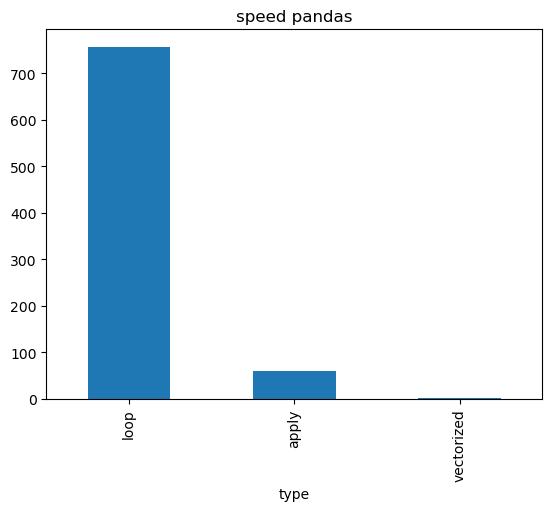

In [15]:
results.set_index('type')['mean'].plot(kind='bar',title='speed pandas')

# 内存效能
[Speed Up Your Pandas Dataframes \- YouTube](https://www.youtube.com/watch?v=u4_c2LDi4b8)


In [16]:
def get_dataset(size):
    df = pd.DataFrame()
    df['position'] = np.random.choice(['left','middle','right'], size)
    df['age'] = np.random.randint(1,50, size)
    df['team'] = np.random.choice(['red','blue','yellow','green'], size)
    df['win'] = np.random.choice(['yes','no'],size)
    df['prob'] = np.random.uniform(0,1, size)
    return df

In [17]:
df2 = get_dataset(2_000_000)

In [18]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 5 columns):
 #   Column    Dtype  
---  ------    -----  
 0   position  object 
 1   age       int64  
 2   team      object 
 3   win       object 
 4   prob      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 76.3+ MB


In [19]:
%timeit df2['age_rank']= df2.groupby(['team','position'])['age'].rank()
%timeit df2['prob_rank']= df2.groupby(['team','position'])['prob'].rank()
%timeit df2['win_prob_rank']= df2.groupby(['team','position','win'])['prob'].rank()

1.02 s ± 31.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.24 s ± 33.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.33 s ± 42.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%memit df2

peak memory: 654.20 MiB, increment: 0.08 MiB


In [21]:
df2.head()

,position,age,team,win,prob,age_rank,prob_rank,win_prob_rank
0,middle,7,green,no,0.581692,21858.0,96561.0,48126.0
1,left,41,red,yes,0.718646,137599.5,119670.0,60133.0
2,left,14,yellow,no,0.411442,46236.0,68682.0,34437.0
3,right,22,yellow,yes,0.864528,72935.5,144111.0,72282.0
4,left,31,yellow,yes,0.588192,104100.0,98150.0,48971.0


改变关键字段数据类型:

In [22]:
df3 = get_dataset(1_000_000)
df3['position'] = df3['position'].astype('category')
df3['team'] = df3['team'].astype('category')
df3.info( )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column    Non-Null Count    Dtype   
---  ------    --------------    -----   
 0   position  1000000 non-null  category
 1   age       1000000 non-null  int64   
 2   team      1000000 non-null  category
 3   win       1000000 non-null  object  
 4   prob      1000000 non-null  float64 
dtypes: category(2), float64(1), int64(1), object(1)
memory usage: 24.8+ MB


In [23]:
df3['age']

0         34
1         19
2         29
3         20
4         44
          ..
999995    46
999996    14
999997    27
999998    19
999999     6
Name: age, Length: 1000000, dtype: int64

## Int 向下转换值范围

- .int8 可以存储从 -128 到 127 的整数。
- .int16 可以存储从 -32768 到 32767 的整数
- .int64 可以存储从 -9223372036854775808 到 9223372036854775807 的整数
